In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic-datasets/train.csv
/kaggle/input/titanic-datasets/test.csv
/kaggle/input/titanic-datasets/gender_submission.csv


# About
In this project we are going to explore Titanic dataset where we do the following tasks:
1. Statistical analysis
1. EDA
1. Predict

Our typical data analysis process will consists of these steps:
**Ask,
Prepare,
Process,
Analyze,
Share,
Act**

# Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
%matplotlib inline

import warnings

warnings.filterwarnings('ignore')

# Lets import our datasets

We are going to import train and test dataset, and we will use supervised machine learning to predict if passenger died or not based on our features. These features are:
1. **Categorical** - Nominal (cabin, embarked), Dichotomous (sex), Oridinal (Pclass)
1. **Numeric** - Discrete (Passenger ID, SibSp, Parch, Survived - our dependent variable), continous (age, fare)
1. **Text Variable** - Ticket, Name

In [3]:
train = pd.read_csv('../input/titanic-datasets/train.csv')
test = pd.read_csv('../input/titanic-datasets/test.csv')

train.sample()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
339,340,0,1,"Blackwell, Mr. Stephen Weart",male,45.0,0,0,113784,35.5,T,S


# Basic info about dataset and cleaning the data

In [4]:
print(train.info())
print('\n')
print('-'*40)
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pa

At the first glance we can see that our features have unequal number of data entries for columns, lets check our missing values:

,Number,Percent
Cabin,687,77.100000
Age,177,19.870000
Embarked,2,0.220000
PassengerId,0,0.000000
Survived,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
SibSp,0,0.000000
Parch,0,0.000000


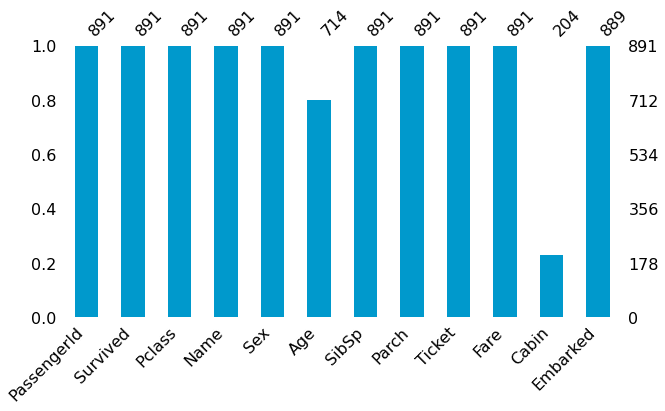

In [5]:
import missingno

missingno.bar(train, figsize=(10,5), color='#0099CC')

def missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = round((df.isnull().sum()/df.shape[0]*100).sort_values(ascending=False),2)
    return pd.concat([total, percent], axis=1,keys=['Number','Percent']).style.background_gradient(cmap='Blues')
missing_data(train)        

,Number,Percent
Cabin,327,78.230000
Age,86,20.570000
Fare,1,0.240000
PassengerId,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
SibSp,0,0.000000
Parch,0,0.000000
Ticket,0,0.000000


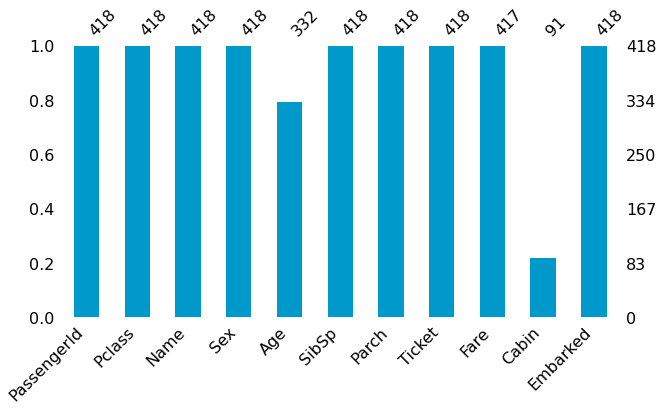

In [6]:
missingno.bar(test, figsize=(10,5),color='#0099CC')

missing_data(test)   

As we can see we have some missing data to deal with:
Lets start with "**embarked**" feature

In [7]:
def feature_count(df, feature):
    total = df[feature].value_counts(dropna=False)
    percent = df[feature].value_counts(normalize=True, dropna=False)*100
    
    df = pd.concat([total,percent], axis=1, keys=['Total','Percent'])
    return df
feature_count(train,'Embarked')

,Total,Percent
S,644,72.278339
C,168,18.855219
Q,77,8.641975
NaN,2,0.224467


In [8]:
import statistics
mode = statistics.mode(train['Embarked'])
mode

'S'

As we can see there are 2 missing data. **Easy way**: we can replace them with mode value 'S', or **Harder way**: we can have a deeper look on this variable in order to find something interesting.

In [9]:
train.loc[train['Embarked'].isnull(),:]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


As we can see both passanger paied fare of 80, are female and are in Pclass number 1. Lets have a look how "Fare" is distributed among all **Pclass** and **Embarked** feature values.

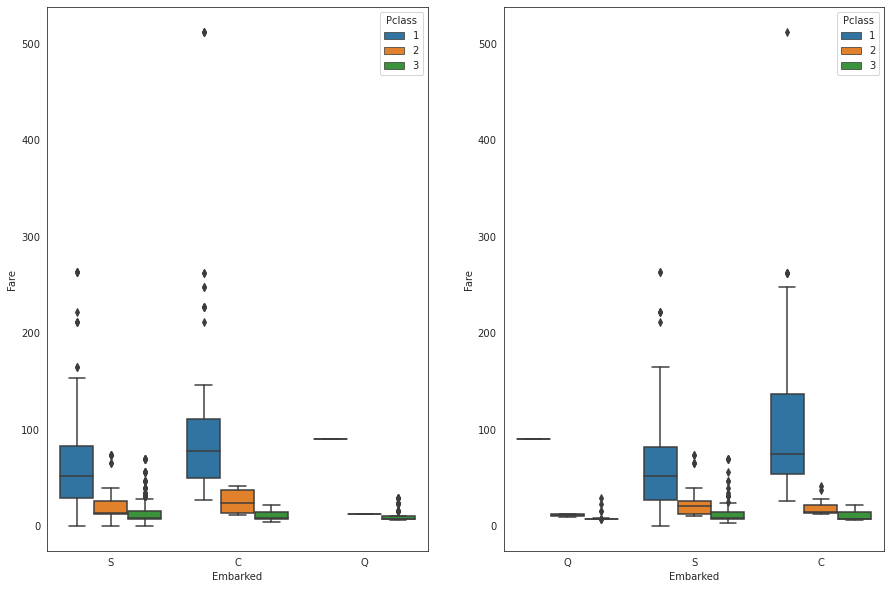

In [10]:
sns.set_style('white')\

fig, (axis1, axis2) = plt.subplots(1,2, figsize=(15,10))
ax1 = sns.boxplot(x='Embarked',y='Fare', hue='Pclass', data=train, ax=axis1)
ax2 = sns.boxplot(x='Embarked', y='Fare',hue='Pclass', data=test, ax =axis2)

As we can see in both training and test set, median fare closes to 80$ is "C" therefore we will fill these missing data with "C".


In [11]:
train['Embarked'].fillna('C', inplace=True)


# **Cabin feature - cleaning**

In [12]:
feature_count(train,'Cabin')[:3]

,Total,Percent
NaN,687,77.104377
B96 B98,4,0.448934
C23 C25 C27,4,0.448934


In [13]:
feature_count(test,'Cabin')[:3]

,Total,Percent
NaN,327,78.229665
B57 B59 B63 B66,3,0.717703
C89,2,0.478469


For both case we are missing many data and we have 2 options:
* we can drop whole feature
* we can find an appropriate way to fill missing values. For example, We may say passengers with cabin record had a higher socio-economic-status then others. We may also say passengers with cabin record were more likely to be taken into consideration when loading into the boat.

Lets combine train and test data and for new we will assign all the null values as "N"

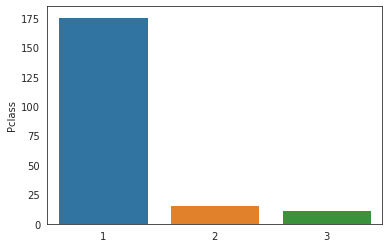

1    176
2     16
3     12
Name: Pclass, dtype: int64

In [14]:
train.loc[train['Cabin'].notnull(),'Pclass'].value_counts()
sns.barplot(x=train.loc[train['Cabin'].notnull(),'Pclass'].value_counts().index,y=train.loc[train['Cabin'].notnull(),'Pclass'].value_counts()
)
plt.show()
train.loc[train['Cabin'].notnull(),'Pclass'].value_counts()

As we can see the most of the passanger with cabin have class number 1, which is probably due to higher economics class

In [15]:
survivers = train['Survived']
train.drop(['Survived'], axis=1, inplace=True)

all_data = pd.concat([train, test], ignore_index= False)

all_data['Cabin'].fillna('N', inplace=True)
all_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,N,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,N,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,N,S


In [16]:
all_data['Cabin'].unique()

array(['N', 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

As we can see all the cabin names start with an English alphabet following by multiple digits. It seems like there are some passengers that had booked multiple cabin rooms in their name. This is because many of them travelled with family. However, they all seem to book under the same letter followed by different numbers. It seems like there is a significance with the letters rather than the numbers. Therefore, we can group these cabins according to the letter of the cabin name.

In [17]:
all_data['Cabin'] = all_data['Cabin'].str.extract(r'(\w{1})')

In [18]:
feature_count(all_data, 'Cabin').style.background_gradient(cmap='Blues')

,Total,Percent
N,1014,77.463713
C,94,7.181054
B,65,4.965623
D,46,3.514133
E,41,3.132162
A,22,1.680672
F,21,1.604278
G,5,0.381971
T,1,0.076394


In [19]:
all_data.groupby('Cabin')['Fare'].agg('mean').sort_values()

Cabin
G     14.205000
F     18.079367
N     19.132707
T     35.500000
A     41.244314
D     53.007339
E     54.564634
C    107.926598
B    122.383078
Name: Fare, dtype: float64

In [20]:
def cabin_estimate(i):
    a = 0
    if i<16:
        a = "G"
    elif i>=16 and i<27:
        a = "F"
    elif i>=27 and i<38:
        a = "T"
    elif i>=38 and i<47:
        a = "A"
    elif i>= 47 and i<53:
        a = "E"
    elif i>= 53 and i<54:
        a = "D"
    elif i>=54 and i<116:
        a = 'C'
    else:
        a = "B"
    return a


Based on average fare price we decided to create function which will estimate potential cabin class.

In [21]:
df_with_N = all_data.loc[all_data['Cabin'] == 'N',:]
df_without_N = all_data.loc[all_data['Cabin'] != 'N',:]

Now we will apply our function to data with cabibe = 'N'

In [22]:
df_with_N['Cabin'] = df_with_N['Fare'].apply(lambda x: cabin_estimate(x))

all_data = pd.concat([df_with_N, df_without_N], axis=0)
all_data.sort_values('PassengerId', inplace=True)

train = all_data.iloc[:train.shape[0],:]
test = all_data.iloc[train.shape[0]:,:]

train['Survived'] = survivers
train.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,G,S,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,1


# Fare feature

In [23]:
test[test['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,B,S


As we can see we have one missing value for 'Fare'. We can take the average of the values where Pclass is 3, Sex is male and Embarked is S

In [24]:
missing_value = test[(test['Pclass']==3) &
                    (test['Sex'] == 'male') &
                    (test['Embarked'] == 'S')]
missing_value_mean = missing_value['Fare'].mean()
test['Fare'].fillna(missing_value_mean, inplace=True)


# Age Feature Missing

In [25]:
print('Train age missing:',train['Age'].isnull().sum()/train['Age'].shape[0]*100,'%')
print('Test age missing:',test['Age'].isnull().sum()/test['Age'].shape[0]*100,'%')

Train age missing: 19.865319865319865 %
Test age missing: 20.574162679425836 %


For both datasets (train, test) we are missing roughly 20% of the data. For this case we can use Random Forest Regressor to impute missing value.

# EDA and Feature Relations
Assumptions:

* **Gender**: More female survived than male
* **Pclass**: Higher socio-economic status passenger survived more than others.
* **Age**: Younger passenger survived more than other passengers.
* **Fare**: Passenger with higher fare survived more that other passengers. This can be quite correlated with Pclass.

**a) Gender / Surived**

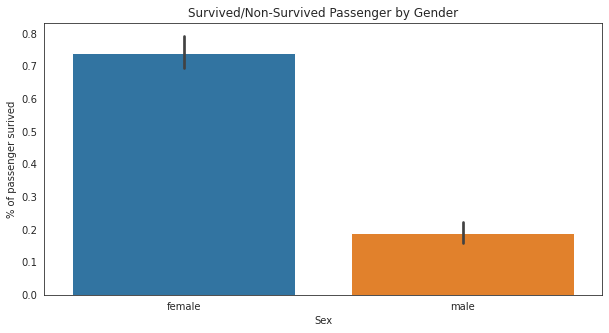

In [26]:
fig = plt.figure(figsize=(10,5))
sns.barplot(data=train, x='Sex',y='Survived',
           order = ['female','male'])
plt.ylabel('% of passenger surived')
plt.title('Survived/Non-Survived Passenger by Gender')
plt.show()

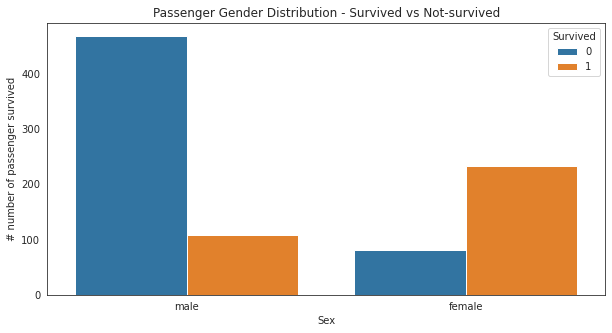

In [27]:
fig = plt.figure(figsize=(10,5))
ax = sns.countplot(data=train, x='Sex',hue='Survived')
ax.set_title('Passenger Gender Distribution - Survived vs Not-survived')
ax.set_ylabel('# number of passenger survived')
plt.show()

As we expected female passengers surived at better rate then male massengers, since women with children have priority.

**b) Pclass / Survived**

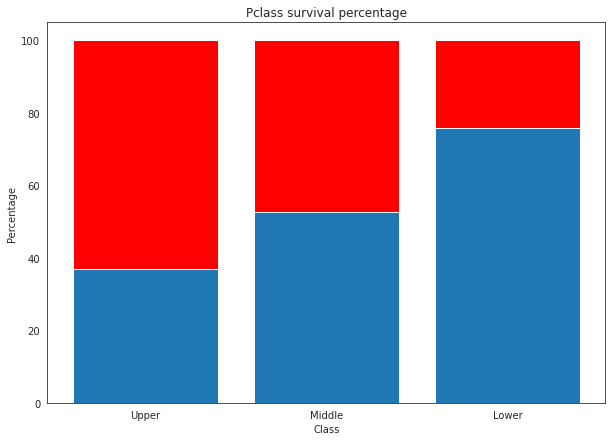

In [28]:
temp = train[['Pclass','Survived','PassengerId']].groupby(['Pclass','Survived']).agg('count').reset_index()
pivot = pd.pivot_table(temp,values='PassengerId', index = 'Pclass', columns='Survived')
pivot.columns = ['No','Yes']
pivot.index = ['Upper','Middle','Lower']
pivot['Total'] = pivot['No'] + pivot['Yes']

No_s = [i / j * 100 for i,j in zip(pivot['No'], pivot['Total'])]
Yes_s = [i / j * 100 for i,j in zip(pivot['Yes'], pivot['Total'])]

fig = plt.figure(figsize=(10,7))
ax  = plt.bar(x=pivot.index, height=No_s)
ax2  = plt.bar(x=pivot.index, height=Yes_s, bottom=No_s, color='Red')
plt.ylabel('Percentage')
plt.xlabel('Class')
plt.title('Pclass survival percentage')
plt.show()


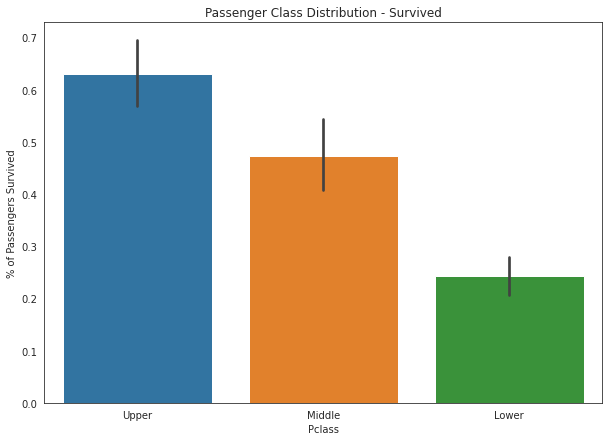

In [29]:
fig = plt.figure(figsize=(10,7))
ax = sns.barplot(data=train, x='Pclass',y='Survived')
ax.set_title('Passenger Class Distribution - Survived')
ax.set_ylabel('% of Passengers Survived')
ax.set_xticklabels(['Upper','Middle','Lower'])
plt.show()

It looks like:
* 63% first class passenger survived titanic tragedy
* 48% second class
* only 24% third class passenger survived

# Kernel Denisity Plots 

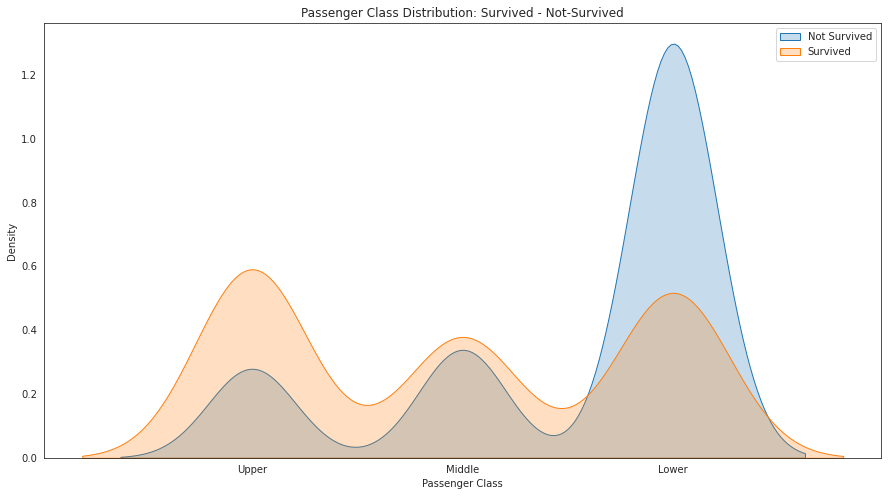

In [30]:
 # Kernel Density Plot Passanger Class
fig = plt.figure(figsize=(15,8),)
ax1=sns.kdeplot(train.loc[train['Survived'] == 0,'Pclass'],
               shade=True,
               label='Not Survived')
ax2=sns.kdeplot(train.loc[train['Survived'] == 1,'Pclass'],
               shade=True, 
               label='Survived', 
              )
plt.title('Passenger Class Distribution: Survived - Not-Survived')
plt.xlabel("Passenger Class")
labels = ['Upper', 'Middle', 'Lower']
plt.xticks(sorted(train['Pclass'].unique()), labels)
plt.legend()

As we can si on KDE plot that passangers in lower class are less likely to survive. It looks like also that lower class passengers survived more than middle class, but if we have a look at the data we can see that there were more passangers in lower class than in middle.

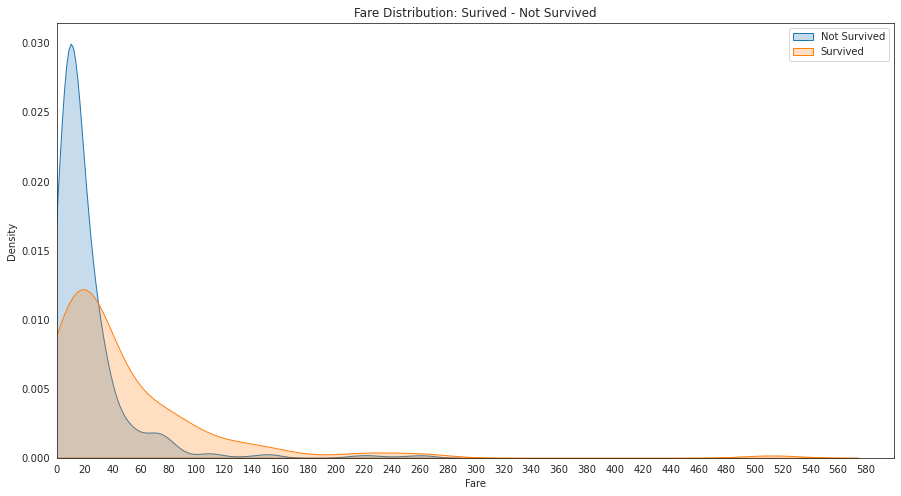

In [31]:
 # Kernel Density Plot Fare 
fig = plt.figure(figsize=(15,8))
ax1 = sns.kdeplot(x=train.loc[train['Survived'] == 0,'Fare'],
                 shade=True,
                 label = 'Not Survived')
ax2= sns.kdeplot(x=train.loc[train['Survived'] == 1,'Fare'],
                shade=True,
                label= 'Survived')
plt.title('Fare Distribution: Surived - Not Survived')
plt.legend()
plt.xlim(0,600)
plt.xticks(np.arange(0,600,20))
# plt.xticks(np.arange(0,600,20))
plt.show()
    

As we can see on our KDE plot,as we can **many people who paid less then 60 dolars didnt survived**. As we can see we have also some outliers, where we can see that p**eople who pay more than ~300 dolars for ticket survived**! Money can buy you also life :P

In [32]:
train.loc[train['Fare'] > 300]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
258,259,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,B,C,1
679,680,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B,C,1
737,738,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B,C,1


For example: [Mr Thomas Drake Martinez](http://www.encyclopedia-titanica.org/titanic-survivor/thomas-cardeza.html) Cardeza was a wealthy banker from Germantown. 

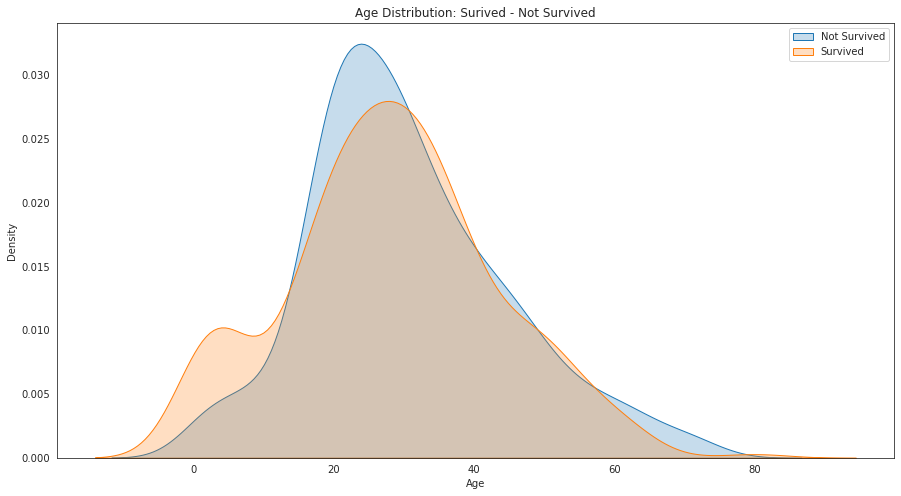

In [33]:
# Kernel Density Plot Age
fig = plt.figure(figsize=(15,8))
ax1 = sns.kdeplot(x=train.loc[train['Survived'] == 0,'Age'],
                 shade=True,
                 label = 'Not Survived')
ax2= sns.kdeplot(x=train.loc[train['Survived'] == 1,'Age'],
                shade=True,
                label= 'Survived')
plt.title('Age Distribution: Surived - Not Survived')
plt.legend()
plt.show()
    


Another very interesting chart where we can see that distribution of Not Survived**** and **Survived** is rougly the same, however we have some **outliers**. As we can see **infants and kids survived more since they have bigger priority**.

In [34]:
train.loc[train['Age'] < 5, 'Survived'].value_counts(normalize=True)*100

1    67.5
0    32.5
Name: Survived, dtype: float64

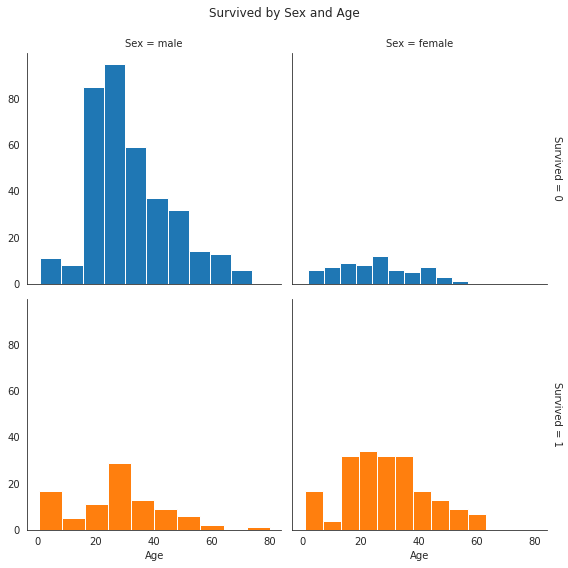

In [35]:
g = sns.FacetGrid(train,col='Sex', size=4, row='Survived', margin_titles=True, hue='Survived')
g = g.map(plt.hist, 'Age')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Survived by Sex and Age')
plt.show()

As we can see on the above chart, female passengers have bigger priorty than males. Lets check age groups now.

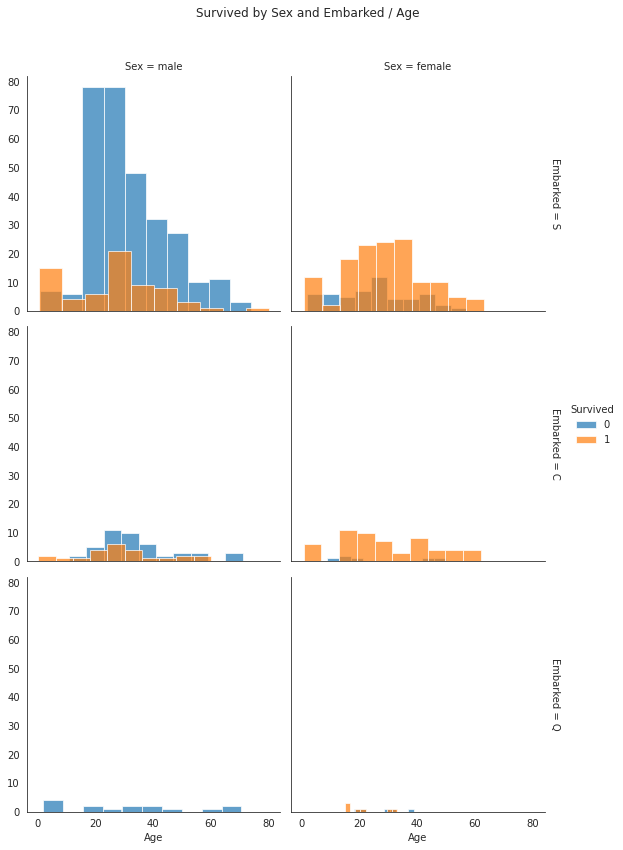

In [36]:
g = sns.FacetGrid(train,col='Sex', size=4, row='Embarked', margin_titles=True, hue='Survived')
g = g.map(plt.hist, 'Age', alpha=0.7).add_legend()
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Survived by Sex and Embarked / Age')
plt.show()

In [37]:
print('Percentage of passengers died based on where they boarded:','\n')
print(train.loc[train['Survived']==0,'Embarked'].value_counts()/train.loc[:,'Embarked'].value_counts()*100)
print('-'*50,'\n')
print('Percentage of passengers survived based on where they boarded:','\n')
print(train.loc[train['Survived']==1,'Embarked'].value_counts()/train.loc[:,'Embarked'].value_counts()*100)
print('-'*50,'\n')


Percentage of passengers died based on where they boarded: 

S    66.304348
C    44.117647
Q    61.038961
Name: Embarked, dtype: float64
-------------------------------------------------- 

Percentage of passengers survived based on where they boarded: 

S    33.695652
C    55.882353
Q    38.961039
Name: Embarked, dtype: float64
-------------------------------------------------- 



**Another interesting insights:**
1. More than 60% of the passengers died who boarded on Southampton
1. More than 55% of the passengers lived who boarded on Cherbourg(C)
1. Pretty much every male that boarded on Queenstown(Q) did not survive
1. There were very few females boarded on Queenstown, however, most of them survived


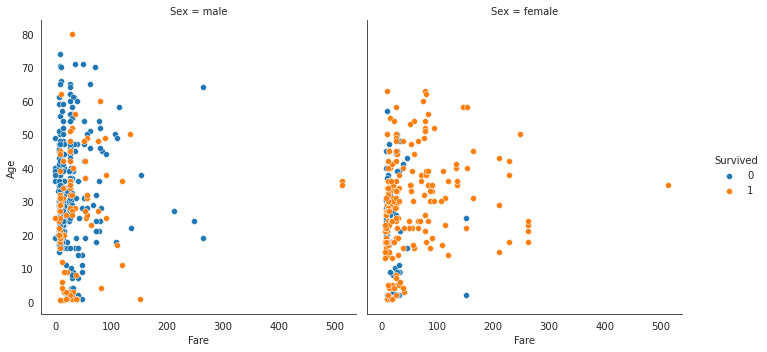

In [38]:
g = sns.FacetGrid(train, col='Sex', hue='Survived',size=5, margin_titles = True)
g = g.map(sns.scatterplot, 'Fare','Age').add_legend()



# Statistical Overview
We will start with basic descriptive statistics

In [39]:
train.describe(exclude='O')

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Survived
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208,0.383838
std,257.353842,0.836071,14.526497,1.102743,0.806057,49.693429,0.486592
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,20.125000,0.000000,0.000000,7.910400,0.000000
50%,446.000000,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000
75%,668.500000,3.000000,38.000000,1.000000,0.000000,31.000000,1.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000


In [40]:
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,8,3
top,"Moen, Mr. Sigurd Hansen",male,1601,G,S
freq,1,577,7,464,644


In [41]:
survived_summary = train.groupby('Survived').agg('mean').reset_index().drop(['PassengerId','Pclass'], axis=1)
survived_summary


,Survived,Age,SibSp,Parch,Fare
0,0,30.626179,0.553734,0.329690,22.117887
1,1,28.343690,0.473684,0.464912,48.395408


**Insights:**
* Average age for passangers who surived = 28 years
* Average age for passangers who didnt survive = 30 years

In [42]:
survived_summary = train.groupby('Sex').agg('mean').reset_index().drop(['PassengerId','Pclass'], axis=1)
survived_summary


,Sex,Age,SibSp,Parch,Fare,Survived
0,female,27.915709,0.694268,0.649682,44.479818,0.742038
1,male,30.726645,0.429809,0.235702,25.523893,0.188908


In [43]:
survived_summary = train.groupby('Pclass').agg('mean').reset_index().drop(['PassengerId'], axis=1)
survived_summary

,Pclass,Age,SibSp,Parch,Fare,Survived
0,1,38.233441,0.416667,0.356481,84.154687,0.629630
1,2,29.877630,0.402174,0.380435,20.662183,0.472826
2,3,25.140620,0.615071,0.393075,13.675550,0.242363


Correlation heatmap

In [44]:
train['Sex'] = train['Sex'].map({'male':1,'female':0})
test['Sex'] = test['Sex'].map({'male':1,'female':0})

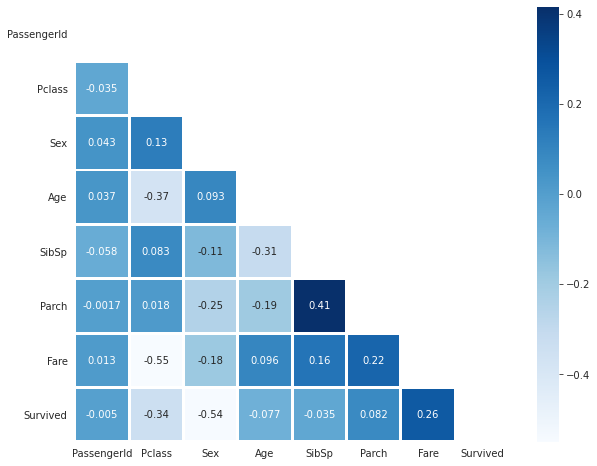

In [45]:
# import numpy as np
corr = train.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(15/1.5,12/1.5))
sns.heatmap(corr,
           mask=mask,
           cmap='Blues',
           linewidths=2,
           linecolor='white',
           fmt='.2g',
           annot=True,
           square=True)

plt.show()

**Interesting correlations:**
* Pclass - Fare: passenger who was in lower class payed less
* Pclass - Survived: passenger who was in lower class mosty likely didnt survive
* Fare - Surivved: passenger who paied less also have bigger chance to survive

Lets make statistical test for correlation!

In [46]:
from scipy.stats import pearsonr
r, p = pearsonr(train['Sex'], train['Survived'])


def show_pvalues_corr(df,sign_level):
    variables = []
    pvalues = []
    for i in df.select_dtypes(exclude='O').columns:
        for n in df.select_dtypes(exclude='O'):
            try:
                r, p = pearsonr(df[i],df[n])
                variables.append(f'{i}/{n}')
                pvalues.append(p)     
            except:
                continue
    variables = pd.Series(variables)
    pvalues = pd.Series(pvalues)

    df_pvalue = pd.concat([variables, pvalues], axis=1)
    df_pvalue.columns = ['Variable','P-value']
    return df_pvalue.loc[df_pvalue['P-value']<=sign_level].drop_duplicates('P-value')

show_pvalues_corr(train,0.5)


,Variable,P-value
0,PassengerId/PassengerId,0.000000e+00
1,PassengerId/Pclass,2.946911e-01
2,PassengerId/Sex,2.003691e-01
3,PassengerId/SibSp,8.613183e-02
9,Pclass/Sex,7.850524e-05
10,Pclass/SibSp,1.311041e-02
12,Pclass/Fare,1.967386e-71
13,Pclass/Survived,2.537047e-25
17,Sex/SibSp,6.076215e-04
18,Sex/Parch,1.073933e-13


**Correlation between these variables is significant.**

## Confidence intervals
Construct three 95% confidence intervals: one for the proportion of women who smoke, one for the proportion of men who smoke, and one for the difference in these proportions.

In [47]:
female_survived = train.loc[train['Sex'] == 0,'Survived']
male_survived = train.loc[train['Sex'] == 1,'Survived']


In [48]:
from statsmodels.stats.proportion import proportion_confint
ci_low, ci_upp = proportion_confint(sum(female_survived==1), len(female_survived), alpha=0.05, method='normal') #normal method for CI
low = pd.Series(ci_low)*100
upp = pd.Series(ci_upp)*100

ci = pd.DataFrame([low, upp],index=['Lower','Upper'])
ci.columns = ['Bounds - Female']
ci


,Bounds - Female
Lower,69.364616
Upper,79.043027


In [49]:
ci_low, ci_upp = proportion_confint(sum(male_survived==1), len(male_survived), alpha=0.05, method='normal') 
low = pd.Series(ci_low)*100
upp = pd.Series(ci_upp)*100

ci = pd.DataFrame([low, upp],index=['Lower','Upper'])
ci.columns = ['Bounds - Male']
ci


,Bounds - Male
Lower,15.696920
Upper,22.084709


**Results**:
* With 95% confidence we estimate that population proportion of female who survived is **between  69% and 79%.**
* With 95% confidence we estimate that population proportion of male who survived is **between  15% and 22%.**

**Lets have a look on diference between means. For this case we will use Welch t-test:**

Welch’s t-test, unlike Student’s t-test, does not have the assumption of equal variance (however, both tests have the assumption of normality). When two groups have equal sample sizes and variances, Welch’s tends to give the same result as Student’s. However, when sample sizes and variances are unequal, Student’s t-test is quite unreliable; Welch’s tends perform better.

* Lets check if there is sifnigicant difference between mean age of passengers who survived and who didnt.

**H0**: Mean age of passengers who survived = Mean age of passengers who didnt survive

**H1**: Mean age of passengers who survived != Mean age of passengers who didnt survive

**Assmuptions**: The t-tests assumes that the means of the different samples are normally distributed. By the central limit theorem, means of samples from a population with finite variance approach a normal distribution regardless of the distribution of the population. Rules of thumb say that the sample means are basically normally distributed as long as the sample size is at least 20 or 30. For a t-test to be valid on a sample of smaller size, the population distribution would have to be approximately normal.

In [50]:
from scipy.stats import ttest_ind #statitics library needed to perform Welch t-tests

mean_age_survived = train.loc[train['Survived']==1 ,'Age']
mean_age_not_survived = train.loc[train['Survived']==0,'Age']
mean_age_survived

stat, p = ttest_ind(mean_age_survived, mean_age_not_survived, equal_var=False, nan_policy='omit') #omit - ignore NAN, equal_var = False - perform Welch t-test
print(f'P-value: {p}')
print(f'We reject null hypotesis? {p<0.05}')

P-value: 0.041189651625877406
We reject null hypotesis? True


* **P-value** is < then 0.05 therefore we will reject our null hypotetis. We estimate that mean age for passengers who survived and who didnt **is different**.

# Feature engineering

Feature engineering is an informal topic, but one that is absolutely known and agreed to be key to success in applied machine learning.
**It is important to remember that we will create new features in such ways that will not cause multicollinearity(when there is a relationship among independent variables) to occur.**

Name lenght

In [51]:
train['name_length'] = train['Name'].apply(lambda x: len(x))
test['name_length'] = test['Name'].apply(lambda x: len(x))


In [52]:
def name_len_group(x):
    size = ''
    if x <= 20:
        size = 'short'
    elif x<= 35:
        size = 'medium'
    elif x<= 45:
        size = 'long'
    else:
        size='huge'
    return size


train['nLength_group'] = train['name_length'].apply(lambda x: name_len_group(x))
test['nLength_group'] = test['name_length'].apply(lambda x: name_len_group(x))

## Getting Title from Name

In [53]:
train['title'] = train['Name'].apply(lambda x: x.split('.')[0].split(',')[1].strip())
test['title'] = test['Name'].apply(lambda x: x.split('.')[0].split(',')[1].strip())
train['title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

As we can see some titles are quite unique! Lets map these titles.

In [54]:
def title_mapping(x):
    feature = ''
    if x in ['the Countess','Capt','Lady','Sir','Jonkheer','Don','Major','Col', 'Rev', 'Dona', 'Dr']:
        feature = 'Rare'
    elif x in ['Ms', 'Mlle']:
        feature = 'Miss'
    elif x == 'Mme':
        feature = 'Mrs'
    else:
        feature = x
    return feature
train['title'] = train['title'].apply(lambda x: title_mapping(x))    
test['title'] = test['title'].apply(lambda x: title_mapping(x)) 

## Family size

In [55]:
train['family_size'] = train['SibSp'] + train['Parch'] + 1 
test['family_size'] = test['SibSp'] + test['Parch'] + 1

def family_group(x):  
    size = ''
    if (x <= 1):
        size = 'alone'
    elif (x <= 4):
        size = 'small'
    else:
        size = 'large'
    return size

train['family_group'] = train['family_size'].apply(lambda x: family_group(x))
test['family_group'] = test['family_size'].apply(lambda x: family_group(x))

Is passanger alone?

In [56]:
train['alone'] = train['family_size'].apply(lambda x: 1 if x<2 else 0)
test['alone'] = test['family_size'].apply(lambda x: 1 if x<2 else 0)

* **Lets get rid of Ticket feature, it is not usefull for us, we already extracted Cabin from this Feature**
* **We will drop PassangerId as well, this feature dont give us any information**

In [57]:
train.drop('Ticket', axis=1, inplace=True)
test.drop('Ticket', axis=1, inplace=True)

train.drop('PassengerId', axis=1, inplace=True)
test.drop('PassengerId', axis=1, inplace=True)

## Fare for passanger
It seems like Fare column kept a record of the total fare rather than the fare of individual passenger, therefore we calculate fare for individual

In [58]:
train['ind_fare'] = train['Fare'] / train['family_size']
test['ind_fare'] = test['Fare'] / test['family_size']

def fare_group(x):    
    fare= ''
    if x <= 4:
        fare = 'Very low'
    elif x <= 10:
        fare = 'Low'
    elif x <= 20:
        fare = 'Mid'
    elif x <= 45:
        fare = 'High'
    else:
        fare = "Very high"
    return fare

train['fare_group'] = train['ind_fare'].apply(lambda x: fare_group(x))
test['fare_group'] = test['ind_fare'].apply(lambda x: fare_group(x))

# Lets create dummy variables

Generally, a dummy variable is a placeholder for a variable that will be integrated over, summed over, or marginalized.   However, in machine learning, it often describes the individual variables in a one-hot encoding scheme. Thus, dummy or Boolean variables are qualitative variables that can only take the value 0 or 1 to indicate the absence or presence of a specified condition.  These “truth” variables are used to sort data into mutually exclusive categories or to trigger off/on commands.  

**How are Dummy Variables Used in Machine Learning?**
These variables are most often used in regression, latent class analysis or one-hot encodig. They’re also used whenever you’re working with categorical variables that have no quantifiable relationship with each other.

More info [here](https://deepai.org/machine-learning-glossary-and-terms/dummy-variable)

In [59]:
train = pd.get_dummies(train, columns=['title',"Pclass", 'Cabin','Embarked','nLength_group', 'family_group', 'fare_group'], drop_first=False)
test = pd.get_dummies(test, columns=['title',"Pclass", 'Cabin','Embarked','nLength_group', 'family_group', 'fare_group'], drop_first=False)

train.drop(['family_size','Name', 'Fare','name_length'], axis=1, inplace=True)
test.drop(['Name','family_size',"Fare",'name_length'], axis=1, inplace=True)

We have to use drop_first = True in order to avoid multicollinearity
1. **Multicollinearity** refers to a condition in which the independent variables are correlated to each other. Multicollinearity can cause problems when you fit the model and interpret the results. The variables of the dataset should be independent of each other to overdue the problem of multicollinearity.

1. To avoid or remove **multicollinearity** in the dataset after one-hot encoding using pd.get_dummies, you can drop one of the categories and hence removing collinearity between the categorical features. Sklearn provides this feature by including drop_first=True in pd.get_dummies.

**Example**:
For example, if you have a variable gender, you don't need both a male and female dummy. If male=1 then the person is a male and if male=0 then the person is female. For the presence of hundreds of categories, dropping the first column does not affect much.

# Imputing missing age

* As we recall we stil have some missing data in "age" feature. We will use random forest regressor to imput missing data.
* Lets rearranging the columns so that I can easily use the dataframe to predict the missing age values. 

In [60]:
train = pd.concat([train[["Survived", "Age", "Sex","SibSp","Parch"]], train.loc[:,"alone":]], axis=1)
test = pd.concat([test[["Age", "Sex","SibSp","Parch"]], test.loc[:,"alone":]], axis=1)

In [61]:
from sklearn.ensemble import RandomForestRegressor

def fill_missing(df):
    age_df = df.loc[:,'Age':]
    temporary_train = age_df[age_df['Age'].notnull()]
    temporary_test = age_df[age_df['Age'].isnull()]
    
    Y = temporary_train['Age']
    x = temporary_train.loc[:,'Sex':]
    
    rfr = RandomForestRegressor(n_estimators=1500, n_jobs = -1)
    rfr.fit(x, Y)
    
    predict_age = rfr.predict(temporary_test.loc[:,'Sex':])
    
    df.loc[df['Age'].isnull(),'Age'] = predict_age
    return df


In [62]:
fill_missing(train)
fill_missing(test)

,Age,Sex,SibSp,Parch,alone,ind_fare,title_Master,title_Miss,title_Mr,title_Mrs,...,nLength_group_medium,nLength_group_short,family_group_alone,family_group_large,family_group_small,fare_group_High,fare_group_Low,fare_group_Mid,fare_group_Very high,fare_group_Very low
0,34.500000,1,0,0,1,7.829200,0,0,1,0,...,0,1,1,0,0,0,1,0,0,0
1,47.000000,0,1,0,0,3.500000,0,0,0,1,...,1,0,0,0,1,0,0,0,0,1
2,62.000000,1,0,0,1,9.687500,0,0,1,0,...,1,0,1,0,0,0,1,0,0,0
3,27.000000,1,0,0,1,8.662500,0,0,1,0,...,0,1,1,0,0,0,1,0,0,0
4,22.000000,0,1,1,0,4.095833,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,23.201193,1,0,0,1,8.050000,0,0,1,0,...,0,1,1,0,0,0,1,0,0,0
414,39.000000,0,0,0,1,108.900000,0,0,0,0,...,1,0,1,0,0,0,0,0,1,0
415,38.500000,1,0,0,1,7.250000,0,0,1,0,...,1,0,1,0,0,0,1,0,0,0
416,23.201193,1,0,0,1,8.050000,0,0,1,0,...,0,1,1,0,0,0,1,0,0,0


In [63]:
print('We have',sum(train.isnull().sum()),'missing values in train dataset')
print('We have',sum(test.isnull().sum()),'missing values in test dataset')

We have 0 missing values in train dataset
We have 0 missing values in test dataset


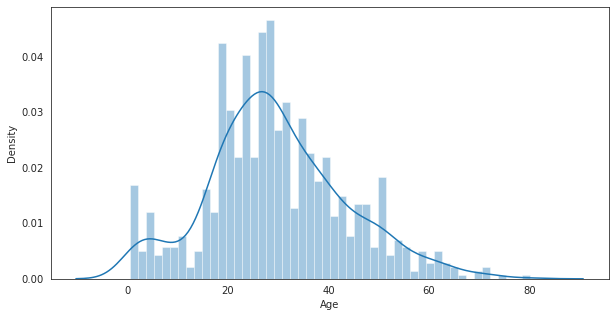

In [64]:
fig = plt.figure(figsize=(10,5))
ax = sns.distplot(train['Age'], bins=50)
plt.show()

In [65]:
def age_group(x):
    age = ''
    if x <= 1:
        age = 'Infant'
    elif x <= 4: 
        age = 'Toddler'
    elif x <= 13:
        age = 'Child'
    elif x <= 18:
        age = 'Teenager'
    elif x <= 35:
        age = 'Young Adult'
    elif x <= 45:
        age = 'Adult'
    elif x <= 55:
        age = 'Middle'
    elif x <= 65:
        age = 'Senior'
    else:
        age = 'Old'
    return age

train['age_group'] = train['Age'].apply(lambda x: age_group(x))
test['age_group'] = test['Age'].apply(lambda x: age_group(x))

#create dummies for adult_group
train = pd.get_dummies(train,columns=['age_group'], drop_first=True)
test = pd.get_dummies(test,columns=['age_group'], drop_first=True);

# Pre-processing data
Lets separate our dependend and independend variable

In [66]:
X = train.drop('Survived', axis=1)
y = train['Survived']

## Spliting training data and feature scaling

Feature scaling: **The first question we need to address – why do we need to scale the variables in our dataset**? Some machine learning algorithms are sensitive to feature scaling while others are virtually invariant to it.

* **Gradien Decent Based Algorithms:** Gradient Descent Based Algorithms
Machine learning algorithms like linear regression, logistic regression, neural network, etc. that use gradient descent as an optimization technique require data to be scaled. The presence of feature value X in the formula will affect the step size of the gradient descent. **The difference in ranges of features will cause different step sizes for each feature.** To ensure that the gradient descent moves smoothly towards the minima and that the steps for gradient descent are updated at the same rate for all the features, we scale the data before feeding it to the model.

* **Distance-Based Algorithms**: Distance algorithms like KNN, K-means, and SVM are most affected by the range of features. This is because behind the scenes they are using distances between data points to determine their similarity.

* **Tree-Based Algorithms**: Tree-based algorithms, on the other hand, are fairly insensitive to the scale of the features. Think about it, a decision tree is only splitting a node based on a single feature. The decision tree splits a node on a feature that increases the homogeneity of the node. This split on a feature is not influenced by other features.  So, there is virtually no effect of the remaining features on the split. This is what makes them invariant to the scale of the features!

**In this case we will use standardization**: Standardization is another scaling technique where the values are centered around the mean with a unit standard deviation. This means that the mean of the attribute becomes zero and the resultant distribution has a unit standard deviation. 

**Standardization**, can be helpful in cases where the data follows a Gaussian distribution. However, this does not have to be necessarily true. Also, unlike normalization, standardization does not have a bounding range. So, even if you have outliers in your data, they will not be affected by standardization

[More info here](http://https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/)



In [67]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=0)

#store columns headers
columns_header = X_train.columns

In [68]:
from sklearn.preprocessing import StandardScaler
std_sc = StandardScaler()

X_train = std_sc.fit_transform(X_train)
X_test = std_sc.fit_transform(X_test)

pd.DataFrame(X_train, columns=columns_header).head()

,Age,Sex,SibSp,Parch,alone,ind_fare,title_Master,title_Miss,title_Mr,title_Mrs,...,fare_group_Very high,fare_group_Very low,age_group_Child,age_group_Infant,age_group_Middle,age_group_Old,age_group_Senior,age_group_Teenager,age_group_Toddler,age_group_Young Adult
0,-0.051706,0.724083,-0.455235,-0.469509,0.803996,-0.281753,-0.226156,-0.499476,0.832575,-0.405046,...,-0.305905,-0.191107,-0.230225,-0.123823,-0.299298,-0.09198,-0.195774,-0.285779,-0.191107,0.986666
1,0.455640,0.724083,-0.455235,-0.469509,0.803996,-0.209699,-0.226156,-0.499476,0.832575,-0.405046,...,-0.305905,-0.191107,-0.230225,-0.123823,-0.299298,-0.09198,-0.195774,-0.285779,-0.191107,-1.013514
2,2.267589,0.724083,-0.455235,-0.469509,0.803996,0.381139,-0.226156,-0.499476,0.832575,-0.405046,...,-0.305905,-0.191107,-0.230225,-0.123823,-0.299298,-0.09198,5.107926,-0.285779,-0.191107,-1.013514
3,1.107941,0.724083,-0.455235,-0.469509,0.803996,0.180831,-0.226156,-0.499476,0.832575,-0.405046,...,-0.305905,-0.191107,-0.230225,-0.123823,-0.299298,-0.09198,-0.195774,-0.285779,-0.191107,-1.013514
4,0.310684,0.724083,-0.455235,-0.469509,0.803996,-0.209699,-0.226156,-0.499476,0.832575,-0.405046,...,-0.305905,-0.191107,-0.230225,-0.123823,-0.299298,-0.09198,-0.195774,-0.285779,-0.191107,0.986666


# Fitting data to our models - Logistic Regression
We will start with logistic regresion.

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, accuracy_score

lgr = LogisticRegression(solver='liblinear', penalty='l1', random_state=42)

lgr.fit(X_train, y_train)

y_predicted = lgr.predict(X_test)

# Lets evaluate our model

There is multiple way how to evaluate our model, we can use:
* Confustion Matrix
* ROC
* AUC

Lets start with **confusion matrix**:

Confusion matrix is a very popular measure used while solving  classification problems. It can be applied to binary classification as well as for multiclass classification problems. 

Confusion matrices represent counts from **predicted and actual values**. The output “TN” stands for True Negative which shows the number of negative examples classified accurately. Similarly, “TP” stands for True Positive which indicates the number of positive examples classified accurately. The term “FP” shows False Positive value, i.e., the number of actual negative examples classified as positive; and “FN” means a False Negative value which is the number of actual positive examples classified as negative. One of the most commonly used metrics while performing classification is **accuracy**. (Accuracy can be misleading if used with imbalanced datasets, and therefore there are other metrics based on confusion matrix which can be useful for evaluating performance.)

,Predicted - Non Survived,Predicted - Survived
Actual - Non Survived,156,28
Actual - Survived,27,84


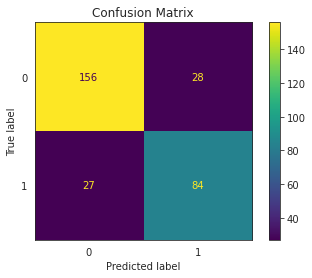

In [70]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def create_cf(y_test, y_predicted, normalized = False):
    
    cm = confusion_matrix(y_test, y_predicted)
    
    if normalized:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        matr = pd.DataFrame(confusion_matrix(y_test, y_predicted), columns=['Predicted - Non Survived', 'Predicted - Survived'],
                        index=['Actual - Non Survived', 'Actual - Survived'])
        cf = ConfusionMatrixDisplay(cm).plot()
        plt.title('Normalized')
        return matr
    else:
        matr = pd.DataFrame(cm, columns=['Predicted - Non Survived', 'Predicted - Survived'],
                        index=['Actual - Non Survived', 'Actual - Survived'])
        cf = ConfusionMatrixDisplay(cm).plot()
        plt.title('Confusion Matrix')
        return matr
    plt.show()

create_cf(y_test, y_predicted, normalized = False)                 

* **True Positive**(TP): values that the model predicted as yes(survived) and is actually yes(survived).
* **True Negative**(TN): values that model predicted as no(not-survived) and is actually no(not-survived)
* **False Positive**(or Type I error): values that model predicted as yes(survived) but actually no(not-survived)
* **False Negative**(or Type II error): values that model predicted as no(not-survived) but actually yes(survived)

We can calculate some interesting metrics:
* True Negative Rate/**Specificity** TN/(TN+FP): How often the model predicts no(not-survived) when it's actually no(not-survived)?

* **Precision** TP/(TP+FP): How often is it correct when the model predicts yes.

* True Positive Rate/Recall/**Sensitivity** TP/(TP+FN): How often the model predicts yes(survived) when it's actually yes(survived)?True 

It is difficult to compare two models with low precision and high recall or vice versa. So to make them comparable, we use **F-Score**. F-score helps to measure Recall and Precision at the same time. It uses Harmonic Mean in place of Arithmetic Mean by punishing the extreme values more.

Lets calculate "**recall**", '**accuracy**', '**precision**' and '**F1-Score**'

In [71]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score

def our_score(y_test, y_predicted):
    ac = accuracy_score(y_test, y_predicted)*100
    re = recall_score(y_test, y_predicted)*100
    pr = precision_score(y_test, y_predicted)*100
    f = f1_score(y_test, y_predicted)*100
    series = pd.Series([ac,re,pr, f], index = ['Accuracy','Recall','Precission', 'F1-Score'])
    return pd.DataFrame(series, columns=['Score'])
our_score(y_test, y_predicted)

,Score
Accuracy,81.355932
Recall,75.675676
Precission,75.000000
F1-Score,75.336323


We can display our metrics using **classification report**.

In [72]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       184
           1       0.75      0.76      0.75       111

    accuracy                           0.81       295
   macro avg       0.80      0.80      0.80       295
weighted avg       0.81      0.81      0.81       295



Lets plot normalized **confusion matrix**

,Predicted - Non Survived,Predicted - Survived
Actual - Non Survived,156,28
Actual - Survived,27,84


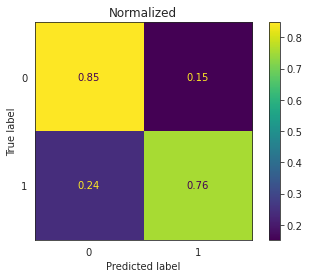

In [73]:
create_cf(y_test, y_predicted, normalized = True)                 

## AUC & ROC Curve
In **Machine Learning**, performance measurement is an essential task. So when it comes to a classification problem, we can count on an **AUC - ROC Curve**. When we need to check or visualize the performance of the multi-class classification problem, we use the AUC (Area Under The Curve) ROC (Receiver Operating Characteristics) curve. It is one of the most important evaluation metrics for checking any classification model’s performance. It is also written as AUROC (Area Under the Receiver Operating Characteristics)

* **ROC** is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0s as 0s and 1s as 1s. By analogy, the Higher the AUC, the better the model is at distinguishing between passagers who survived and who didnt.

An excellent model has AUC near to the 1 which means it has a good measure of separability. A poor model has AUC near to the 0 which means it has the worst measure of separability. In fact, it means it is reciprocating the result. It is predicting 0s as 1s and 1s as 0s. And when AUC is 0.5, it means the model has no class separation capacity whatsoever.

**Example**: When AUC is 0.7, it means there is a 70% chance that the model will be able to distinguish between positive class and negative class.

[More info](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)

ROC AUC:  0.8706913435174305


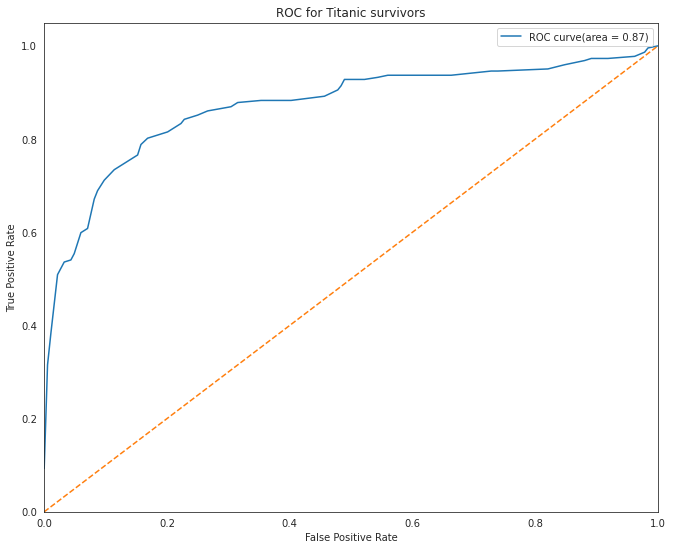

In [74]:
from sklearn.metrics import roc_curve, auc

def plot_roc_auc(X_test, y_test):
    y_score = lgr.decision_function(X_test)

    FPR, TPR, _ = roc_curve(y_test, y_score)
    ROC_AUC = auc(FPR, TPR)
    print ('ROC AUC: ',ROC_AUC)

    plt.figure(figsize =[11,9])
    ax1 = sns.lineplot(FPR, TPR, label= 'ROC curve(area = %0.2f)'%ROC_AUC, ci=None)
    ax2 = sns.lineplot([0,1],[0,1])
    ax2.lines[1].set_linestyle("--")
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for Titanic survivors')
    plt.show()
    
plot_roc_auc(X_test, y_test)

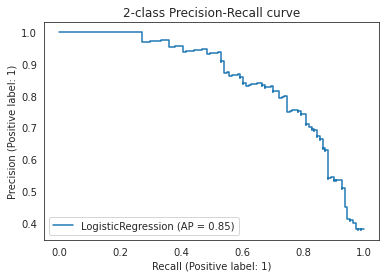

In [75]:
from sklearn.metrics import plot_precision_recall_curve

disp = plot_precision_recall_curve(lgr, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve')
plt.show()

## Cross-validation

To evaluate the performance of any machine learning model we need to test it on some unseen data. Based on the models performance on unseen data we can say weather our model is Under-fitting/Over-fitting/Well generalized. Cross validation (CV) is one of the technique used to test the effectiveness of a **machine learning models**, it is also a re-sampling procedure used to evaluate a model if we have a limited data. To perform CV we need to keep aside a sample/portion of the data on which is not used to train the model, later use this sample for testing/validating.

In this case we will use: **Stratified ShuffleSplit cross-validator**. Provides train/test indices to split data in train/test sets. This cross-validation object is a merge of StratifiedKFold and ShuffleSplit, which returns stratified randomized folds. **The folds are made by preserving the percentage of samples for each class.**

In [76]:
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score

cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=0)

columns_names = X.columns

X = std_sc.fit_transform(X)
accuracies = cross_val_score(LogisticRegression(solver='liblinear'), X, y, cv=cv)

print(f'Cross-Validation accuracy scores: {accuracies}','\n')
print(f'Mean Cross-Validation score: {round(accuracies.mean(),4)}')

Cross-Validation accuracy scores: [0.79820628 0.81165919 0.8206278  0.86547085 0.8206278  0.8161435
 0.82511211 0.86547085 0.81165919 0.8206278 ] 

Mean Cross-Validation score: 0.8256


## Grid Search

A machine learning model has **multiple parameters** that are not trained by the training set. These parameters control the accuracy of the model. Therefore, the **hyperparameters** are particularly important in a data science project.
The hyperparameters are configured up-front and are provided by the caller of the model before the model is trained.

**Grid search** is a tuning technique that attempts to compute the optimum values of hyperparameters. It is an exhaustive search that is performed on a the specific parameter values of a model. The model is also known as an estimator.

[More info](https://medium.com/fintechexplained/what-is-grid-search-c01fe886ef0a)

In [77]:
from sklearn.model_selection import GridSearchCV

C_vals = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
solvers= ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25)
params = {'C': C_vals,
         'solver':solvers}

lgr = LogisticRegression(solver='liblinear')

grid = GridSearchCV(estimator=lgr,
                   param_grid=params, 
                   scoring='accuracy',
                   n_jobs = -1,
                   cv = cv)

grid.fit(X,y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=None, test_size=0.25,
            train_size=None),
             estimator=LogisticRegression(solver='liblinear'), n_jobs=-1,
             param_grid={'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='accuracy')

In [78]:
print(grid.best_estimator_)
print(grid.best_score_)
print(grid.best_params_)
lgr_grid = grid.best_estimator_

LogisticRegression(C=0.1, solver='newton-cg')
0.8246636771300448
{'C': 0.1, 'solver': 'newton-cg'}


# Fitting data to our models - K-Nearest Neighbor Classifier

**K Nearest Neighbor(KNN**) is a very simple, easy to understand, versatile and one of the topmost machine learning algorithms. 

The simple version of the K-nearest neighbor classifier algorithms is to predict the target label by finding the nearest neighbor class. The closest class will be identified using the distance measures like Euclidean distance.

In [79]:
from sklearn.neighbors import KNeighborsClassifier

knn= KNeighborsClassifier(metric='minkowski', p=2)
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=2)

accuracies = cross_val_score(knn, X, y, cv=cv, scoring='accuracy')
print(f'Cross-Validation accuracy scores:{accuracies}')
print(f'Mean Cross-Validation score:{accuracies.mean()}')

Cross-Validation accuracy scores:[0.78026906 0.78923767 0.79820628 0.8161435  0.79372197 0.77578475
 0.79372197 0.80717489 0.77130045 0.8161435 ]
Mean Cross-Validation score:0.794170403587444


## Lets find best possible k value for KNN

In [80]:
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=0)
k_scores = {}
for k in range(1,25):
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, y, cv=cv, scoring='accuracy')
    k_scores[k] = score.mean()
print(f'Mean accuracy scores:{k_scores}')
print(f'Highest score:{max(k_scores, key=k_scores.get)}')
    

Mean accuracy scores:{1: 0.7443946188340808, 2: 0.7690582959641257, 3: 0.7807174887892375, 4: 0.7811659192825112, 5: 0.7860986547085201, 6: 0.7838565022421525, 7: 0.7874439461883409, 8: 0.7807174887892376, 9: 0.7798206278026906, 10: 0.7829596412556055, 11: 0.7847533632286996, 12: 0.7883408071748879, 13: 0.7887892376681613, 14: 0.7919282511210762, 15: 0.7982062780269058, 16: 0.7896860986547085, 17: 0.7995515695067265, 18: 0.7852017937219731, 19: 0.7874439461883409, 20: 0.7775784753363228, 21: 0.7901345291479821, 22: 0.7829596412556052, 23: 0.7869955156950673, 24: 0.7753363228699552}
Highest score:17


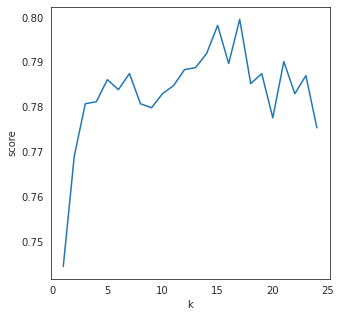

In [81]:
plt.figure(figsize=(5,5))
ax = sns.lineplot([i for i, v in k_scores.items()], [v for i, v in k_scores.items()])
ax.set_xlabel('k')
ax.set_ylabel('score')
plt.show()

## Lets use grid search on KNN clasifier

In [82]:
from sklearn.model_selection import GridSearchCV

k_range = range(1,25)
weights_options = ['uniform','distance']

params = {'n_neighbors':k_range,
         'weights':weights_options}

cv = StratifiedShuffleSplit(n_splits=10, random_state=10)

grid = GridSearchCV(KNeighborsClassifier(), cv=cv, param_grid=params, verbose=False, n_jobs=-1)
grid.fit(X,y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=10, test_size=None,
            train_size=None),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(1, 25),
                         'weights': ['uniform', 'distance']},
             verbose=False)

In [83]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

knn_grid = grid.best_estimator_
knn_grid.score(X,y) 

0.8066666666666666
{'n_neighbors': 5, 'weights': 'uniform'}
KNeighborsClassifier()


0.8619528619528619

## Randomized GridSearch

Random search: set up a grid of hyperparameter values and select random combinations to train the model and score. The number of search iterations is set based on time/resources.

Grid search spends too much time evaluating unpromising regions of the hyperparameter search space because it has to evaluate every single combination in the grid. Random search in contrast, does a better job of exploring the search space and therefore can usually find a good combination of hyperparameters in far fewer iterations.

In [84]:
from sklearn.model_selection import RandomizedSearchCV

k_range = range(1,25)

weights_options = ['uniform','distance']

params = {'n_neighbors':k_range,
         'weights':weights_options}

cv = StratifiedShuffleSplit(n_splits=10, test_size=0.25)

grid = RandomizedSearchCV(KNeighborsClassifier(), cv=cv,param_distributions = params, verbose=False, n_jobs=-1, n_iter=40) #n_jobs = -1 to instruct scikit learn to use all available processors

grid.fit(X,y)

RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=None, test_size=0.25,
            train_size=None),
                   estimator=KNeighborsClassifier(), n_iter=40, n_jobs=-1,
                   param_distributions={'n_neighbors': range(1, 25),
                                        'weights': ['uniform', 'distance']},
                   verbose=False)

In [85]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.7991031390134528
{'weights': 'uniform', 'n_neighbors': 7}
KNeighborsClassifier(n_neighbors=7)


# Support Vector Machines (SVM)

**The Support Vector Machine** is a supervised learning algorithm mostly used for **classification** but it can be used also for **regression**. The main idea is that based on the labeled data (training data) the algorithm tries to find the optimal hyperplane which can be used to classify new data points. In two dimensions the hyperplane is a simple line.
Usually a learning algorithm tries to learn the most common characteristics (what differentiates one class from another) of a class and the classification is based on those representative characteristics learnt (so classification is based on differences between classes). The SVM works in the other way around. It finds the most similar examples between classes. Those will be the support vectors.

[More info](https://towardsdatascience.com/svm-and-kernel-svm-fed02bef1200)

In [86]:
from sklearn.svm import SVC
Cs = [0.001, 0.01, 0.1, 1,1.5,2,2.5,3,4,5, 10] ## penalty parameter C for the error term. 
gammas = [0.0001,0.001, 0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.30, random_state=15)
grid_search = GridSearchCV(SVC(kernel = 'rbf', probability=True), param_grid, cv=cv) ## 'rbf' stands for gaussian kernel
grid_search.fit(X,y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=15, test_size=0.3,
            train_size=None),
             estimator=SVC(probability=True),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 1.5, 2, 2.5, 3, 4, 5, 10],
                         'gamma': [0.0001, 0.001, 0.01, 0.1, 1]})

In [87]:
print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

0.8361940298507463
{'C': 1, 'gamma': 0.01}
SVC(C=1, gamma=0.01, probability=True)


# Random Forrest Classifier

**Random forest** is an ensemble machine learning algorithm.

It is perhaps the most popular and widely used machine learning algorithm given its good or excellent performance across a wide range of classification and regression predictive modeling problems. It is also easy to use given that it has few key hyperparameters and sensible heuristics for configuring these hyperparameters.

* **This algorithm makes decision trees susceptible to high variance if they are not pruned.**

[More info](https://machinelearningmastery.com/random-forest-ensemble-in-python/)

In [88]:
from sklearn.ensemble import RandomForestClassifier

n_estimators = [10,30,50,70,80,150,160, 170,175,180,185];
cv = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=15)

n_estimators = [140,145,150,155,160];
max_depth = range(1,10);
criterions = ['gini', 'entropy'];

params = {'n_estimators':n_estimators,
              'max_depth':max_depth,
              'criterion': criterions
             }
grid = GridSearchCV(RandomForestClassifier(max_features='auto'),param_grid = params, cv=cv, n_jobs= -1)
grid.fit(X,y)


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=15, test_size=0.3,
            train_size=None),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10),
                         'n_estimators': [140, 145, 150, 155, 160]})

In [89]:
print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

0.8361940298507463
{'C': 1, 'gamma': 0.01}
SVC(C=1, gamma=0.01, probability=True)


# Bagging Classifier

In [90]:
from sklearn.ensemble import BaggingClassifier
n_estimators = [10,30,50,70,80,150,160, 170,175,180,185];
cv = StratifiedShuffleSplit(n_splits=10, test_size=.30, random_state=15)

parameters = {'n_estimators':n_estimators,
              
        }
grid = GridSearchCV(BaggingClassifier(base_estimator= None, ## If None, then the base estimator is a decision tree.
                                      bootstrap_features=False),
                                 param_grid=parameters,
                                 cv=cv,
                                 n_jobs = -1)
grid.fit(X,y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=15, test_size=0.3,
            train_size=None),
             estimator=BaggingClassifier(), n_jobs=-1,
             param_grid={'n_estimators': [10, 30, 50, 70, 80, 150, 160, 170,
                                          175, 180, 185]})

In [91]:
print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_) 

0.817910447761194
{'n_estimators': 10}
BaggingClassifier()
